In [1]:
import os
import re
import requests
import zipfile

import nltk

import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from maha.cleaners.functions import remove, normalize
from maha.expressions.general import EXPRESSION_EMOJIS

from collections import Counter
from typing import Callable



%matplotlib inline

In [2]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/yazansh/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/yazansh/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/yazansh/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/yazansh/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/yazansh/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/yazansh/nltk_data...
[nltk_data]    |   Package movie_reviews is already

True

# Introduction

The goal of this notebook is to *practice text preprocessing*


You're part of a team in Twitter that's assigned to create a sentiment analysis model for tweets in Arabic, your task is to prepare the data for training a model to classify wether the tweet has *positive* or *negative* sentiment

## Components of Preprocessing

### Text Cleaning

We need to remove or keep parts of the tweet so that the remaining text is **relevant** to the task at hand 

#### What are the possbile parts to remove or keep?

1. Hashtags
2. Mentions
3. Emojis
4. URLs
5. Numbers
6. English characters
7. Stop words
8. Diactrics
9. Punctiation marks
10. Others

### Stemming / Lemmatisation



### Steps
In this notebook we should:

1. Read the raw data
2. Explore the dataset
3. Text Cleaning
4. Stemming / Lemmatisation

## The Dataset

The dataset for this project is ArSenTD-Lev, a collection of 4,000 labeled tweets in the Levantine dialect, along side the tweet text:

- Country
- Topic (personal, politics, religion, sports, entertainment, others)
- Sentiment (very_negative, negative, neutral, positive, very_positive)
- Sentiment_Expression : implicit, explicit, or none (when neutral)
- Sentiment_Target: The part of the text of which the sentiment was derived

The original dataset is found on the [original website](http://oma-project.com/ArSenL/ArSenTD_Lev_Intro)

and with another copy of the dataset found on the [course website](https://shai-nlp-course.netlify.app/ArSenTD-LEV.tsv)

# Setup

In [3]:
data_dir = os.path.join(os.curdir, "data")
archive_path = os.path.join(data_dir, "arsentd-lev.zip")
tweets_dir = os.path.join(data_dir, "arsentd-lev")

## Download Raw Data



In [4]:
link = "http://oma-project.com/ArSenL/ArSenTD-LEV.zip"

response = requests.get(link)

with open(archive_path, "wb+") as f:
    f.write(response.content)
    
with zipfile.ZipFile(archive_path, 'r') as zip_f:
    zip_f.extractall(tweets_dir)


os.listdir(tweets_dir)

['README.txt', 'ArSenTD-LEV.tsv']

In [5]:
raw_filepath = os.path.join(tweets_dir, "ArSenTD-LEV.tsv")

In [6]:
raw = pd.read_csv(filepath_or_buffer=raw_filepath, sep="\t", encoding="utf_8")

In [7]:
raw.head()

,Tweet,Country,Topic,Sentiment,Sentiment_Expression,Sentiment_Target
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",lebanon,personal,negative,implicit,بريق العيون
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,jordan,sports,positive,explicit,افضل لاعب في العالم
2,لا نخلو من ضغوطات الحياة. فنحن نعيش على أرض أع...,palestine,personal,neutral,none,none
3,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,lebanon,personal,negative,explicit,مصطلحات_لبنانيه
4,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,palestine,personal,negative,explicit,س لم تعد كما ك


# Explaratory Data Analysis (EDA)

In [8]:
data = raw.copy(deep=True)

In [9]:
data["Sentiment"] = data["Sentiment"].replace(
    {"very_negative": "negative", "very_positive": "positive"}
)

In [10]:
sentiment_count = data.groupby(by="Sentiment", as_index=False).count()[["Sentiment", "Tweet"]]

/tmp/ipykernel_35387/3624011578.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


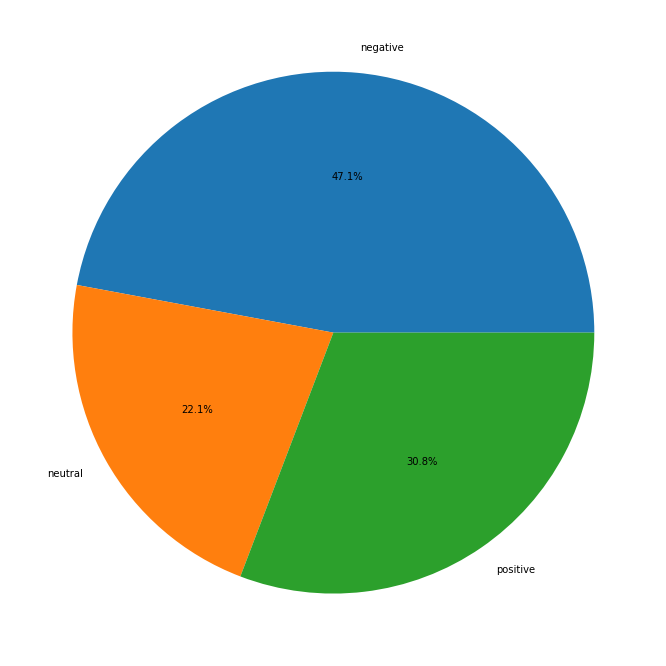

In [11]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.pie(x=sentiment_count["Tweet"].to_list(), 
       labels=sentiment_count["Sentiment"].to_list(),
       autopct='%1.1f%%'
      )

fig.show()

In [12]:
data["word_count"] = data["Tweet"].apply(lambda x: len(x.split(" ")))

In [13]:
data["word_count"].describe()

count    4000.00000
mean       22.69825
std         3.28495
min         7.00000
25%        21.00000
50%        23.00000
75%        25.00000
max        35.00000
Name: word_count, dtype: float64

In [14]:
data["char_count"] = data["Tweet"].apply(len)
data["char_count"].describe()

count    4000.000000
mean      131.364250
std        14.314636
min        42.000000
25%       128.000000
50%       138.000000
75%       140.000000
max       147.000000
Name: char_count, dtype: float64

## Vocabulary

Vocabulary: the set of unique vocabulary in the corpus
and optionally the count of each vocab

In [15]:
all_words = [word for tweet in data["Tweet"] for word in tweet.split(" ")]

In [16]:
vocab = Counter(all_words)

Explore the most and least common words in the vocab

In [17]:
print("Least Common")
vocab.most_common()[-10:]

Least Common


[('الريحة', 1),
 ('نقلاً', 1),
 ('مباشراً', 1),
 ('نشرة', 1),
 ('الرياضية', 1),
 ('8:30', 1),
 ('"العرب"', 1),
 ('حمود', 1),
 ('📍', 1),
 ('https://t.co/oUstA9G7dM', 1)]

In [18]:
print("Most Common")
vocab.most_common(n=10)

Most Common


[('من', 1906),
 ('في', 1610),
 ('.', 1105),
 ('و', 963),
 ('على', 913),
 ('الله', 787),
 ('ما', 769),
 ('لا', 656),
 ('،', 589),
 ('كل', 493)]

In [19]:
counts = list(vocab.values())

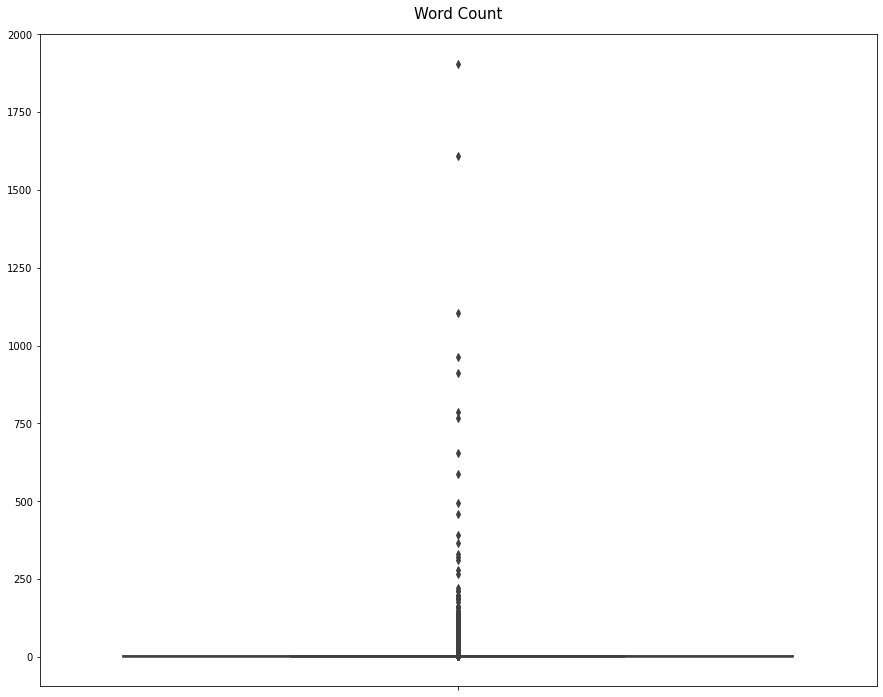

In [20]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

In [21]:
stop_words = stopwords.words("arabic")
all_words_pruned = [word for tweet in data["Tweet"] for word in tweet.split(" ") if word not in stop_words]

In [22]:
pruned_vocab = Counter(all_words_pruned) 

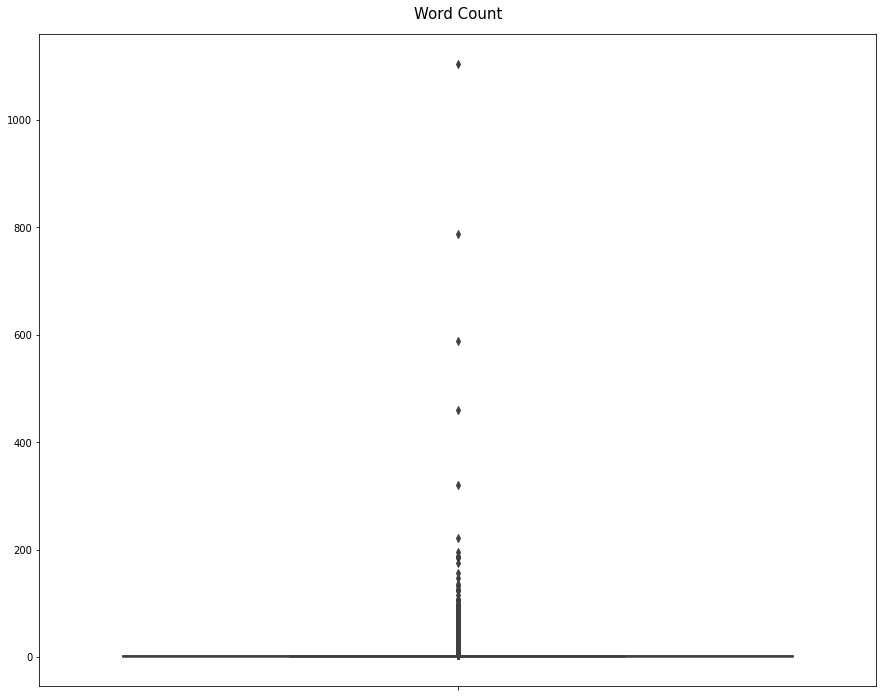

In [23]:
counts = list(pruned_vocab.values())

fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

> Removing stop words still produces a box plot with this many outliers indicates that more cleaning is necessary

# Text Cleaning

In [24]:
sample = data.iloc[102]["Tweet"]
sample

'هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA'

In [25]:
def test_clean_fn(fn: Callable, sample: str) -> str:
    print(sample, fn(sample), sep="\n")

## Stop Words

In [26]:
stop_words = stopwords.words("arabic")

def remove_stop_words(text: str) -> str:
    return " ".join([word for word in text.split(" ") if word not in stop_words])


test_clean_fn(remove_stop_words, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف نراه يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA


## Remove Hashtags

[Regex to remove hashtag](https://regexr.com/3gkpo)

In [27]:
hashtag_re = re.compile(pattern="#[\w\d]+")

def remove_hashtag(text: str) -> str:
    return hashtag_re.sub(repl="", string=text)

test_clean_fn(remove_hashtag, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم .  . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA


## Remove Mention

In [28]:
mention_re = re.compile("\B@\w+")
def remove_mention(text: str) -> str:
    # TODO: Look for a suitable way to remove mentions from a text
    # TIP: Look for a regex expression
    return mention_re.sub(repl="", string=text)
    
test_clean_fn(remove_mention, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم . #LEITOT .  شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA


## Remove Punctuation Marks

In [29]:
punc_re = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")
def remove_punctation(text: str) -> str:
    # TODO: Look for a suitable way to remove punctiation marks from a text
    # TIP: Look for a regex expression
    return punc_re.sub(repl="", string=text)
    
test_clean_fn(remove_punctation, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم  LEITOT  okiq8e شوف ابن اختي شوف 🤗 httpstcoZmVMl4sOqA


## Remove HTTP URLs

In [30]:
url_re = re.compile(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)")
def remove_urls(text: str) -> str:
    # TODO: Look for a suitable way to remove urls from a text
    # TIP: Look for a regex expression
    return url_re.sub(repl="", string=text)
    
test_clean_fn(remove_urls, sample)

هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 https://t.co/ZmVMl4sOqA
هدف لا نراه كل يوم . #LEITOT . @oki_q8e شوف ابن اختي شوف 🤗 


## Remove Diactrics

In [31]:
diactircs_re = re.compile("[\u064B-\u0652]")

def remove_diactrics(text: str) -> str:
    # TODO: Implement this function using the diactrics_re
    return diactircs_re.sub(repl="", string=text)
    
test_clean_fn(remove_diactrics, data.iloc[0]["Tweet"])

"أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد من يحب ، حتى بريق العيون يختفي فيصبح ذابلاً منطفئًا، يتحول ربيعه الى خريف.". @gbraniiat
"أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد من يحب ، حتى بريق العيون يختفي فيصبح ذابلا منطفئا، يتحول ربيعه الى خريف.". @gbraniiat


## Remove Numbers

In [32]:
numbers_re = re.compile("\d")
def remove_numbers(text: str) -> str:
    # TODO: Implement remove numbers
    return numbers_re.sub(repl="", string=text)
    
test_clean_fn(remove_numbers, data.iloc[65]["Tweet"])

@GundiOmer @WahidBarzane 6- برامج واجندات لسب جميع صحابة رسول الله صل الله عليه وسلم 7- تدمير منطقة الشرق الاوسط و… https://t.co/Mey9HB1979
@GundiOmer @WahidBarzane - برامج واجندات لسب جميع صحابة رسول الله صل الله عليه وسلم - تدمير منطقة الشرق الاوسط و… https://t.co/MeyHB


## Remove English Characters

In [33]:
english_chars_re = re.compile("[A-Za-z]")
def remove_english_characters(text: str) -> str:
    # TODO: Implement remove english characters
    return english_chars_re.sub(repl="", string=text)

## Remove Most and Least Common Words

In [34]:
stop_words_pruned = [remove_stop_words(tweet) for tweet in data["Tweet"]]

pruned_all_words = [word for tweet in stop_words_pruned for word in tweet.split(" ")]

pruned_vocab = Counter(pruned_all_words)


In [35]:
## TODO: define a list of least occurent words
rare_words = []
common_words = [word for word, count in pruned_vocab.items() if count > 100]

def remove_rare_words(text: str) -> str:
    return " ".join([word for word in text.split(" ") if word not in rare_words])
    
def remove_common_words(text: str) -> str:
    # TODO: Implement
    return " ".join([word for word in text.split(" ") if word not in common_words])

## Add Space Around Emojis

In [36]:
emojis_regex = re.compile(EXPRESSION_EMOJIS.pattern) 


def space_around_emojis(text: str) -> str:
    chars = [' ' + char + ' ' if emojis_regex.match(char) else char for char in text]
    return ''.join(chars)
    
test_clean_fn(space_around_emojis, "طبعا😂✋🏻🌹🌹🌹")

طبعا😂✋🏻🌹🌹🌹
طبعا 😂  ✋  🏻  🌹  🌹  🌹 


## Remove Multiple Whitespace

In [37]:
multiple_space_re = re.compile("\s{2,}")
def remove_multiple_whitespace(text: str) -> str:
    return multiple_space_re.sub(repl=" ", string=text)

## Clean All

In [38]:
def clean_all(text: str) -> str:
    text = space_around_emojis(text)
    text = remove_urls(text)
    text = remove_hashtag(text)
    text = remove_mention(text)
    text = remove_punctation(text)
    text = remove_numbers(text)
    text = remove_diactrics(text)
    text = remove_english_characters(text)
    text = remove_stop_words(text)
    text = remove_common_words(text)
    text = remove_rare_words(text)
    text = remove_multiple_whitespace(text)
    ## To remove trailing and leading whitespaces
    text = text.strip()
    
    text = remove(text=text, all_harakat=True, tatweel=True, punctuations=True)
    text = normalize(text=text, all=True)
    
    
    return text

In [39]:
data["clean_text"] = data["Tweet"].apply(clean_all)

# Text Normalisation

In [40]:
# https://www.nltk.org/_modules/nltk/stem/isri.html

stemmer = ISRIStemmer()

In [41]:
stemmer.stem("يذهبون")

'ذهب'

In [42]:
stemmed_data = []
for sample in data["clean_text"]:
    words = sample.split(" ")
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_data.append(" ".join(stemmed_words))



In [43]:
print(data["clean_text"][0], stemmed_data[0])

اومن بان الانسان ينطفي جماله ابتعاد يحب بريق العيون يختفي فيصبح ذابلا منطفيا يتحول ربيعه خريف اوم بان انس نطف جمل بعد يحب برق عين خفي صبح ذبل نطف تحل ربع خرف


In [44]:
data["clean_stemmed"] = stemmed_data

# Post Processsing Exploration

In [45]:
# TODO: Plot a box plot of the remaining unique tokens
all_words = [word for tweet in stemmed_data for word in tweet.split(" ")]

vocab = Counter(all_words)

counts = list(vocab.values())

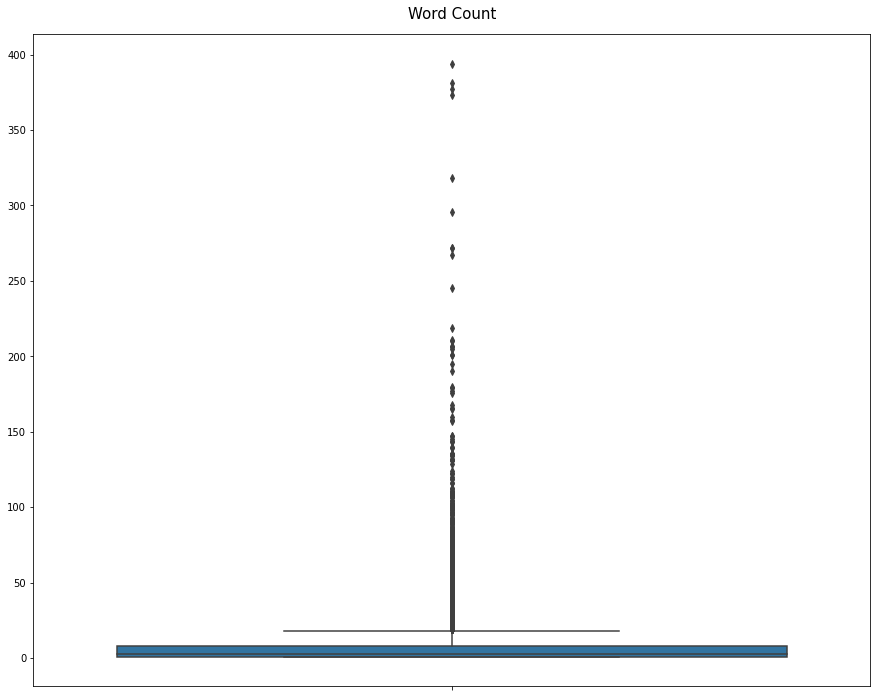

In [46]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(y=counts, ax=ax)
ax.set_title("Word Count", fontdict=dict(size=15), pad=15)

plt.show()

In [47]:
vocab.most_common(n=10)

[('قدم', 394),
 ('علم', 381),
 ('سعد', 377),
 ('سلم', 373),
 ('قلب', 318),
 ('حكم', 296),
 ('جمع', 272),
 ('عمل', 272),
 ('😂', 267),
 ('كلم', 245)]

In [48]:
len(vocab)

6420

# Save New Data

In [49]:
data_dir = os.path.join(os.curdir, "data")
filepath = os.path.join(data_dir, "clean-tweets.tsv")

data.to_csv(path_or_buf=filepath, sep="\t", index=False)